# Research hackathon year 1 - Fraudulent job advertisement detection

Data: http://emscad.samos.aegean.gr/

Aim: Engineering structured data to predict fraudulent job advertisement.

### Imports

In [49]:
import pandas as pd
import numpy as np

# For feature engineering
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import nltk.tokenize as nt
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thaole/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/thaole/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
# Load data
raw_data = pd.read_csv("emscad_v1.csv")
raw_data.head(3)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f


In [51]:
# Undersample the dataset
balanced_data= raw_data[raw_data['in_balanced_dataset']=='t']
balanced_data.to_csv('under_sampled_data.csv', index=False)

## Data Cleaning

In [52]:
#Function to return wordcounts in strings
def clean_sequence(string):
    string = string.encode("ascii", "ignore").decode()
    string_words = word_tokenize(string)
    return len([word for word in string_words if word.lower() not in stop_words])

def clean_data(data):
    #Change all boolean variables to binary representations.
    data['fraudulent'] = np.where(data['fraudulent']=='t', 1, 0)
    data['telecommuting'] = np.where(data['telecommuting']=='t', 1, 0)
    data['has_company_logo'] = np.where(data['has_company_logo']=='t', 1, 0)
    data['has_questions'] = np.where(data['has_questions']=='t', 1, 0)
    
    #Get wordcounts
    data['description'] = data['description'].apply(lambda x: clean_sequence(str(x)))
    data['benefits'] = data['benefits'].apply(lambda x: clean_sequence(str(x)))
    data['requirements'] = data['requirements'].apply(lambda x: clean_sequence(str(x)))
    data['company_profile'] = data['company_profile'].apply(lambda x: clean_sequence(str(x)))
    return data


def change_to_ordinal(data):
    scale_mapper = {'Entry level':1, 'Not Applicable':0, 'Associate':3, 'Internship':2, 'Mid-Senior level':4, 'Director':5,'Executive':5}
    data['required_experience 1'] = data['required_experience'].replace(scale_mapper)
    data['required_experience 1'] = data['required_experience 1'].replace(np.nan, 0, regex=True)
    return data

list1 = ['..','!!','??']
spamwords_fraudulent = ['home', 'extra' 'easy money', 'week', 'online', 'no experience']

#Function to check whether a text has consecutive puntuation.
def consecutive_punct(list1, list2):
    if any( str in list1 for str in list2):
        return 1
    return 0

In [53]:
balanced_data= clean_data(balanced_data)
balanced_data

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
144,Forward Cap.,NaN,NaN,NaN,1,33,1,1,0,0,0,NaN,NaN,NaN,NaN,NaN,1,t
180,Sales Executive,"PK, SD, Karachi",Sales,NaN,1,8,8,8,0,0,0,NaN,NaN,NaN,NaN,Sales,1,t
493,Admin Assistant/ Receptionist,"US, CA, Los Angeles",NaN,23040-28800,1,53,45,1,0,0,0,Full-time,Entry level,High School or equivalent,Computer Software,Administrative,1,t
1152,Administrative Assistant,"US, MI, FLINT",NaN,NaN,1,187,1,1,0,0,0,Full-time,Entry level,Unspecified,Hospital & Health Care,Administrative,1,t
1297,Custom Products Account Maestro,"US, NY, Port Chester",NaN,NaN,1,9211,9184,1,0,0,0,Full-time,Not Applicable,NaN,Consumer Goods,Customer Service,0,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17827,Student Positions Part-Time and Full-Time.,"US, CA, Los Angeles",NaN,NaN,1,83,1,1,0,0,0,Part-time,NaN,NaN,NaN,NaN,1,t
17828,Sales Associate,"AU, NSW, Sydney",Sales and Marketing,NaN,1,87,188,87,0,0,1,NaN,NaN,NaN,NaN,NaN,1,t
17829,Android Developer,"PL, MZ, Warsaw",NaN,NaN,1,54,218,38,0,0,0,NaN,NaN,NaN,NaN,NaN,1,t
17830,Payroll Clerk,"US, NY, New York",NaN,NaN,1,89,51,40,0,0,0,Full-time,NaN,NaN,Apparel & Fashion,Accounting/Auditing,1,t


## Feature Engineering

In [54]:
# requiring low education
balanced_data['low_required_education'] = 0
balanced_data.loc[balanced_data['required_education'] == ( 'High School or equivalent' or 'Unspecified' or 'Some High School Coursework' or '' or 'Vocational - HS Diploma' or 'Vocational - Degree' or 'Some College Coursework Completed'), ['low_required_education']] = 1



In [55]:
balanced_data['low_required_education'].value_counts()

0    772
1    128
Name: low_required_education, dtype: int64

In [56]:
# feature contains money_in_title, money_in_description
currencies= ['$','£','¥','€']

# create a function to check if a string contains any currency symbol
def contains_currency(s):
    return any(currency in s for currency in currencies)

raw_data= raw_data[raw_data['in_balanced_dataset']=='t']

# apply the function
balanced_data['money_in_title'] = raw_data['title'].apply(contains_currency).astype(int)
balanced_data['money_in_desc'] = raw_data['description'].apply(contains_currency).astype(int)

In [57]:
# check if text contains consecutive punctuations
punctuations = ['..','!!','??']

# create a function to check if a string contains consecutive punctuations
def contains_cons_punc(s):
    return any(punct in s for punct in punctuations)

# apply the function
balanced_data['cons_punc_des'] = raw_data['description'].apply(contains_cons_punc).astype(int)
balanced_data['cons_punc_title'] = raw_data['title'].apply(contains_cons_punc).astype(int)

In [58]:
# create some boolean variables
balanced_data["has_short_company_profile"]= np.where(balanced_data['company_profile'] < 10, 1, 0)
balanced_data["has_short_requirements"]= np.where(balanced_data['requirements'] < 10, 1, 0)

In [59]:
balanced_data.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'in_balanced_dataset', 'low_required_education',
       'money_in_title', 'money_in_desc', 'cons_punc_des', 'cons_punc_title',
       'has_short_company_profile', 'has_short_requirements'],
      dtype='object')

In [60]:
final_data = balanced_data[['fraudulent', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions',
       'money_in_title', 'money_in_desc', 'cons_punc_des',
       'cons_punc_title', 'low_required_education',
       'has_short_company_profile', 'has_short_requirements']]
final_data

,fraudulent,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,money_in_title,money_in_desc,cons_punc_des,cons_punc_title,low_required_education,has_short_company_profile,has_short_requirements
144,1,1,33,1,1,0,0,0,0,0,0,0,0,1,1
180,1,1,8,8,8,0,0,0,0,0,0,0,0,1,1
493,1,1,53,45,1,0,0,0,0,0,0,0,1,1,0
1152,1,1,187,1,1,0,0,0,0,1,0,0,0,1,1
1297,0,1,9211,9184,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17827,1,1,83,1,1,0,0,0,0,1,0,0,0,1,1
17828,1,1,87,188,87,0,0,1,0,0,0,0,0,1,0
17829,1,1,54,218,38,0,0,0,0,0,0,0,0,1,0
17830,1,1,89,51,40,0,0,0,0,1,0,0,0,1,0


## Feature selection

[0.06371092 0.12794268 0.0814268  0.05816689 0.01015525 0.18112161
 0.04450321 0.0408855  0.04405139 0.01530219 0.00179137 0.0425913
 0.27399416 0.01435672]


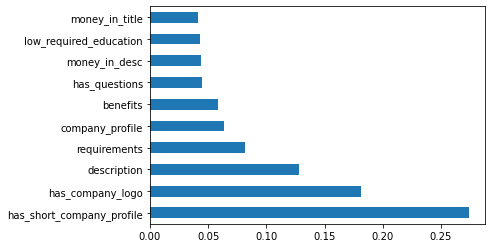

In [61]:
X = final_data.iloc[:,1:16] 
y = final_data.iloc[:,0]    
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Result shows that the 10 most important features are: description, has_short_company_profile, company_profile, requirements, benefits, has_company_logom low_required_education, has_questions, telecommuting, has_short_requirements.

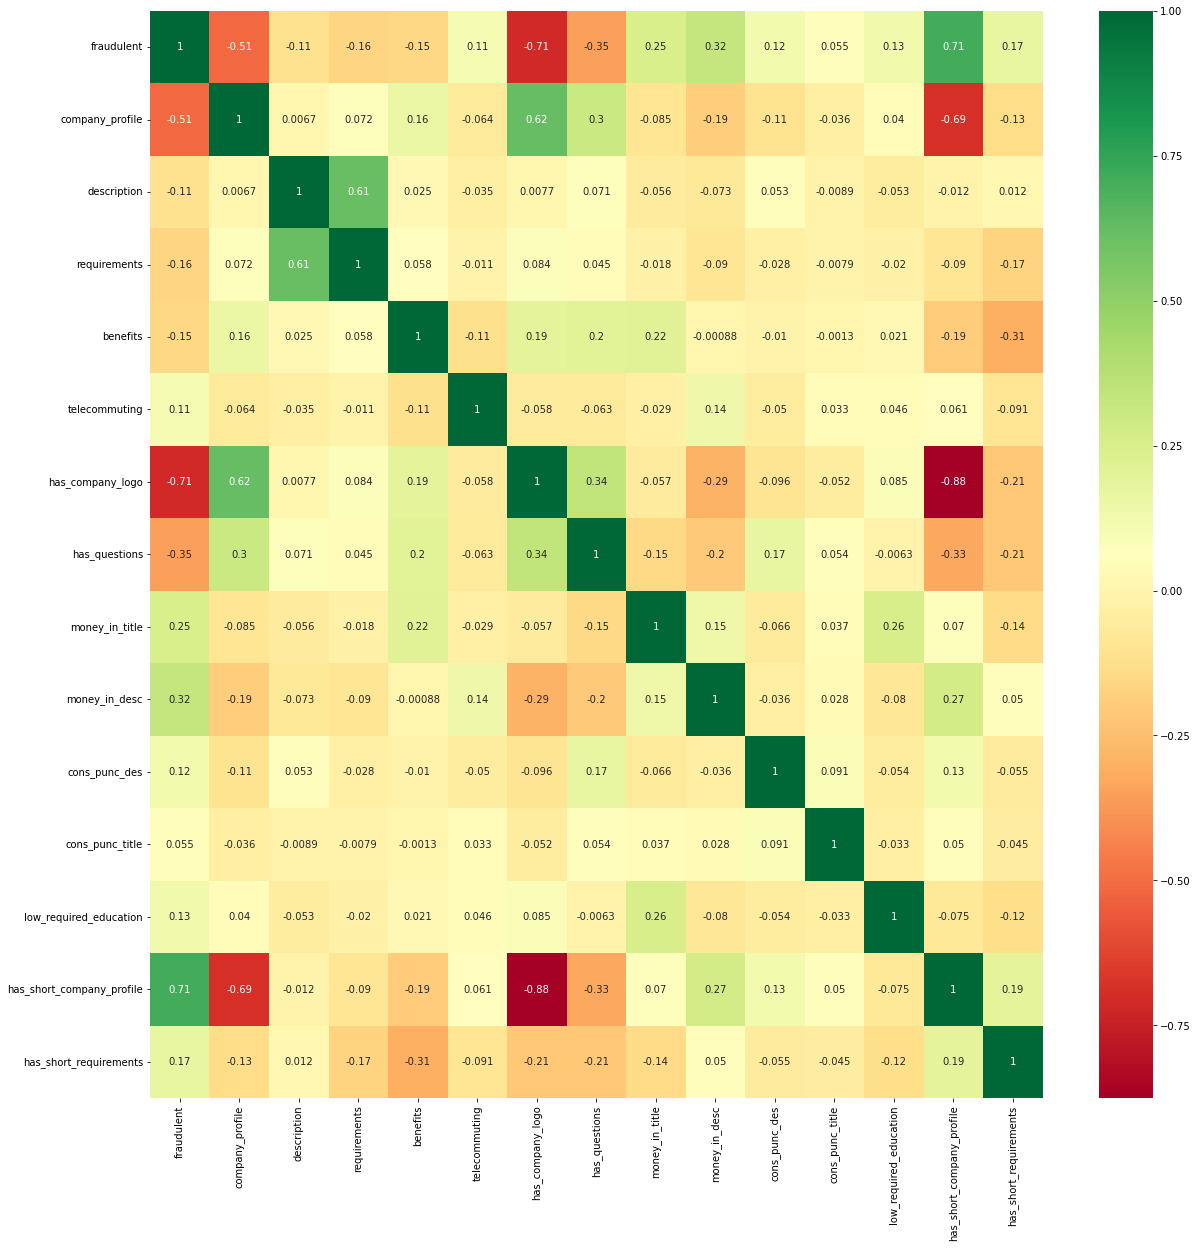

In [62]:
import seaborn as sns

#get correlations of each features in dataset
corrmat = final_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(final_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Result shows that the most important features are: has_short_company_profile, has_company_logo, company_profile, has_short_description, low_require_education, requirements, benefits, has_short_requirements, telecommuting.

## Selected features


In [63]:
selected_data = final_data[['description', 'has_short_company_profile', 'company_profile', 'requirements', 'benefits', 
                            'has_company_logo', 'low_required_education', 'has_questions', 'telecommuting', 
                            'has_short_requirements', 'fraudulent']]

In [64]:
selected_data.to_csv('selected_data.csv', index=False)

In [65]:
selected_data

,description,has_short_company_profile,company_profile,requirements,benefits,has_company_logo,low_required_education,has_questions,telecommuting,has_short_requirements,fraudulent
144,33,1,1,1,1,0,0,0,0,1,1
180,8,1,1,8,8,0,0,0,0,1,1
493,53,1,1,45,1,0,1,0,0,0,1
1152,187,1,1,1,1,0,0,0,0,1,1
1297,9211,1,1,9184,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
17827,83,1,1,1,1,0,0,0,0,1,1
17828,87,1,1,188,87,0,0,1,0,0,1
17829,54,1,1,218,38,0,0,0,0,0,1
17830,89,1,1,51,40,0,0,0,0,0,1
